In [2]:
import tensorflow as tf
import os
import pandas as pd
import numpy as np
import sounddevice as sd

In [3]:
import matplotlib.pyplot as plt
from IPython import display
from tensorflow.keras import layers
from tensorflow.keras import models

In [4]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [5]:
sources = ["acoustic", "electronic", "synthetic"]
families = ["bass", "brass", "flute", "guitar", "keyboard", "mallet", "organ", "reed", "string", "synth_lead", "vocal"]

In [13]:
# spectrograms_train = tf.saved_model.load("data/processed/spectrograms_train").read_value()
# spectrograms_test = tf.saved_model.load("data/processed/spectrograms_test").read_value()
labels_src_train = tf.saved_model.load("data/processed/labels_src_train").read_value()
labels_src_test = tf.saved_model.load("data/processed/labels_src_test").read_value()

In [7]:
audio_train = tf.saved_model.load("data/processed/audio_train").read_value()
audio_test = tf.saved_model.load("data/processed/audio_test").read_value()
audio_train = tf.expand_dims(audio_train, axis=-1)
audio_test = tf.expand_dims(audio_test, axis=-1)

In [14]:
# print(spectrograms_train.shape)
print(labels_src_train.shape)
# print(spectrograms_test.shape)
print(labels_src_test.shape)
print(audio_train.shape)
print(audio_test.shape)

(3072,)
(1024,)
(3072, 64000, 1)
(1024, 64000, 1)


In [35]:
# input_shape = spectrograms_train.shape[1:-1]
input_shape = audio_train.shape[1:]
print('Input shape:', input_shape)
num_labels = len(sources)

# Instantiate the `tf.keras.layers.Normalization` layer.
norm_layer = layers.Normalization()
# Fit the state of the layer to the spectrograms
# with `Normalization.adapt`.
norm_layer.adapt(data=audio_train)

model = models.Sequential([
    layers.Input(shape=input_shape),
    norm_layer,
    layers.Conv1D(32, 3, activation='relu'),
    layers.MaxPooling1D(),
    layers.Conv1D(64, 3, activation='relu'),
    layers.MaxPooling1D(),
    layers.Dropout(0.25),
    # layers.Resizing(*input_shape),
    layers.Flatten(),
    # layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_labels),
])

model.summary()

Input shape: (64000, 1)
Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_9 (Normalizat  (None, 64000, 1)         3         
 ion)                                                            
                                                                 
 conv1d_12 (Conv1D)          (None, 63998, 32)         128       
                                                                 
 max_pooling1d_9 (MaxPooling  (None, 31999, 32)        0         
 1D)                                                             
                                                                 
 conv1d_13 (Conv1D)          (None, 31997, 64)         6208      
                                                                 
 max_pooling1d_10 (MaxPoolin  (None, 15998, 64)        0         
 g1D)                                                            
                              

In [36]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

In [37]:
EPOCHS = 10
history = model.fit(
    x=audio_train,
    y=labels_src_train,
    validation_data=(audio_test, labels_src_test),
    epochs=EPOCHS,
    # callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=2),
)

Epoch 1/10
96/96 [==============================] - 18s 184ms/step - loss: 3.2718 - accuracy: 0.4834 - val_loss: 0.8350 - val_accuracy: 0.5898
Epoch 2/10
96/96 [==============================] - 13s 139ms/step - loss: 0.6453 - accuracy: 0.7220 - val_loss: 0.5829 - val_accuracy: 0.7686
Epoch 3/10
96/96 [==============================] - 17s 176ms/step - loss: 0.3905 - accuracy: 0.8499 - val_loss: 0.7124 - val_accuracy: 0.7432
Epoch 4/10
96/96 [==============================] - 17s 177ms/step - loss: 0.2588 - accuracy: 0.9046 - val_loss: 0.5560 - val_accuracy: 0.7773
Epoch 5/10
96/96 [==============================] - 17s 175ms/step - loss: 0.1869 - accuracy: 0.9391 - val_loss: 0.6412 - val_accuracy: 0.7900
Epoch 6/10
96/96 [==============================] - 17s 181ms/step - loss: 0.1280 - accuracy: 0.9593 - val_loss: 0.6431 - val_accuracy: 0.8018
Epoch 7/10
96/96 [==============================] - 17s 173ms/step - loss: 0.1067 - accuracy: 0.9688 - val_loss: 0.5308 - val_accuracy: 0.7998

Text(0, 0.5, 'Accuracy [%]')

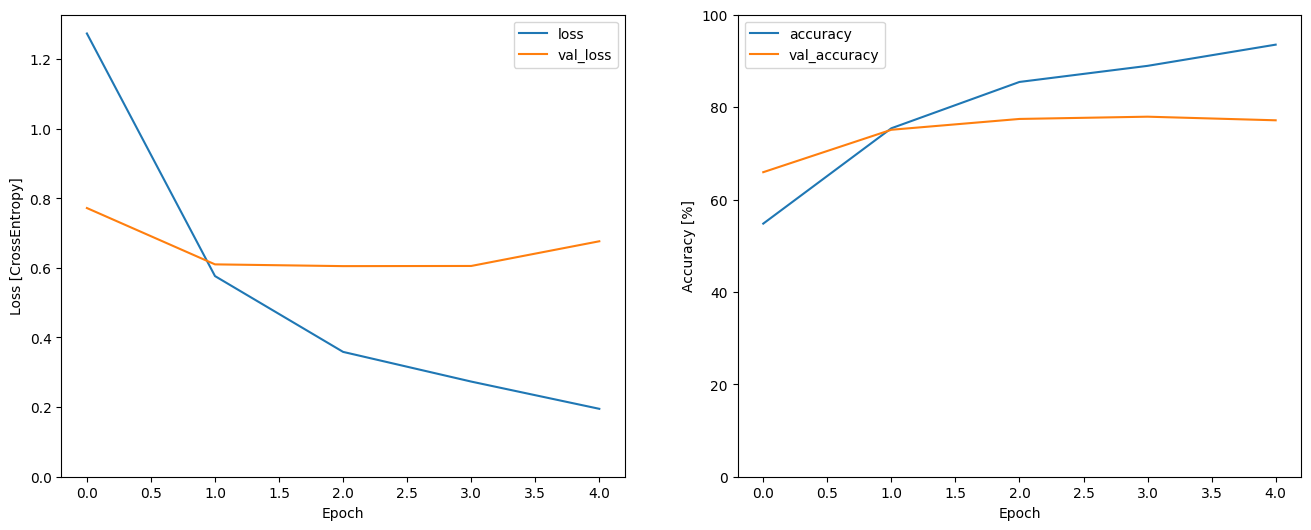

In [29]:
metrics = history.history
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch')
plt.ylabel('Loss [CrossEntropy]')

plt.subplot(1,2,2)
plt.plot(history.epoch, 100*np.array(metrics['accuracy']), 100*np.array(metrics['val_accuracy']))
plt.legend(['accuracy', 'val_accuracy'])
plt.ylim([0, 100])
plt.xlabel('Epoch')
plt.ylabel('Accuracy [%]')

In [11]:
model.save("./models/sound_classifier_lr")

INFO:tensorflow:Assets written to: ./models/sound_classifier_lr\assets


In [61]:
model = tf.keras.models.load_model("./models/model1")

In [66]:
x = tf.io.read_file("./samples/piano-G3.wav")
x, sample_rate = tf.audio.decode_wav(x, desired_channels=1, desired_samples=16000,)
x = tf.squeeze(x, axis=-1)
waveform = x
x = get_spectrogram(x)
x = x[tf.newaxis,...]

In [67]:
prediction = model(x)

In [68]:
prediction

<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[ 0.860001  ,  0.1342126 , -0.85429704]], dtype=float32)>

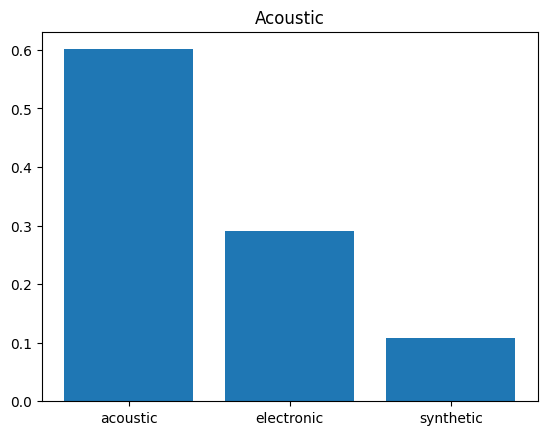

In [69]:
plt.bar(sources, tf.nn.softmax(prediction[0]))
plt.title('Acoustic')
plt.show()

display.display(display.Audio(waveform, rate=16000))